In [1]:
# change the saving path
exp_name = "oragneandapple"
exp_details = "experiment for horser and zebr swapping, date: 3/9/19 "

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_small_xian as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_AE_128FC import DAE
#from models.model_AE_VGG16 import AE_VGG16

from random import randint
os.environ["CUDA_VISIBLE_DEVICES"] = "5, 6"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 2


In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 224
cuda = torch.cuda.is_available()
save_path = 'Experiments/' + exp_name
if not os.path.isdir(save_path):
    os.makedirs(save_path)
    os.makedirs(save_path + '/weight')
    os.makedirs(save_path + '/images')

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?


Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
    transition=False,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco_small_xian.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['orange', 'apple'],transition = True)
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)
len(cocoDataset)

loading annotations into memory...
Done (t=18.17s)
creating index...
index created!


494

In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['apple', 'orange'], dtype='<U6')

torch.Size([128, 3, 224, 224])
(224, 224, 3)


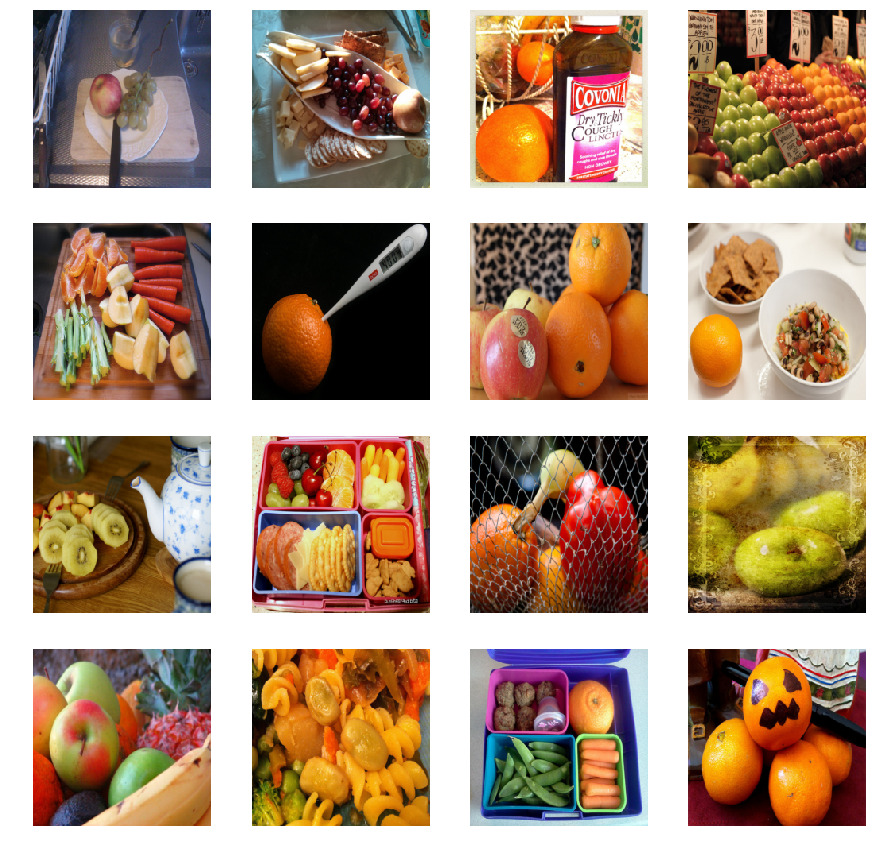

In [9]:
for im, mask, obj, _, _ in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask, obj, _, _ in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

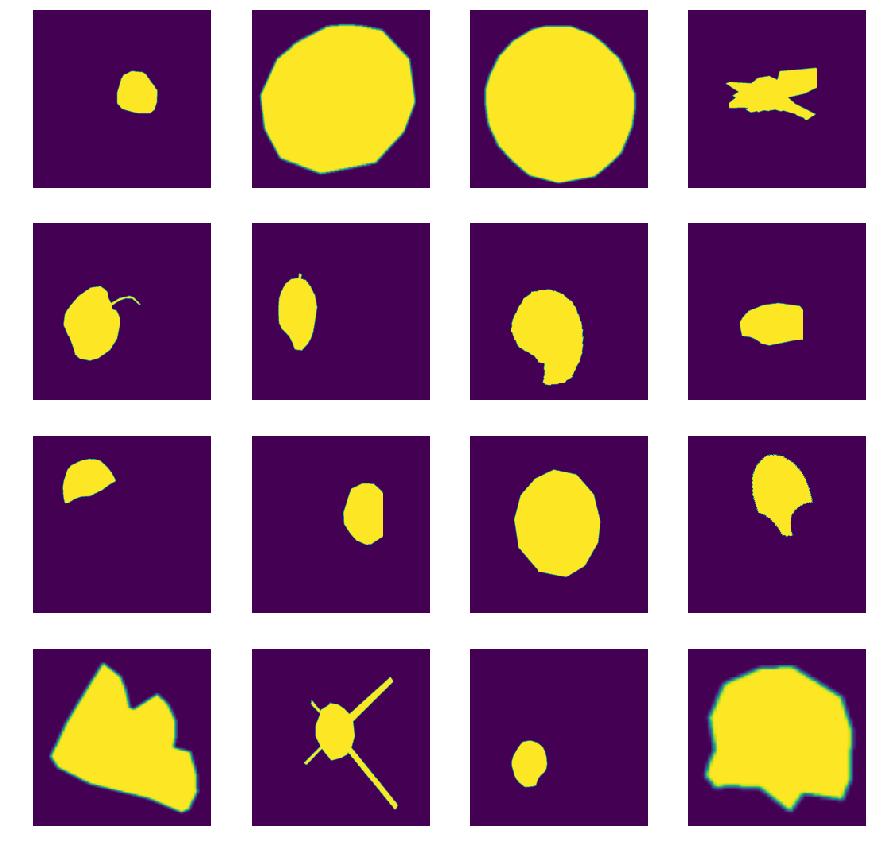

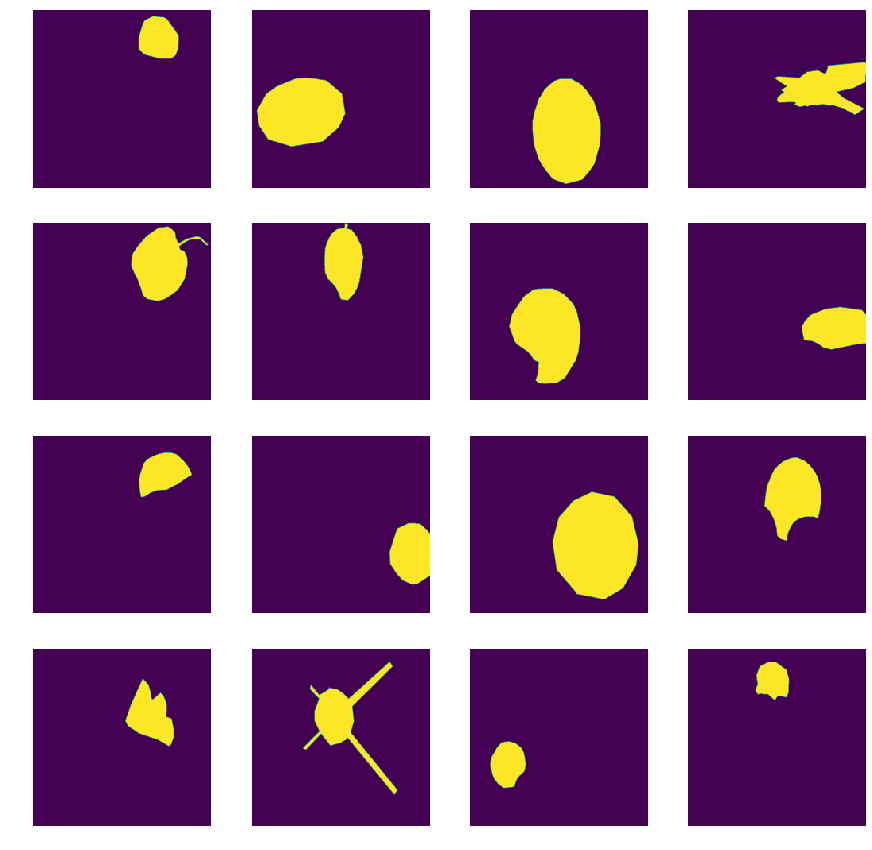

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f2.subplots_adjust()
i = 0
j = 0
'''
mask_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])
'''

for im, masks, obj, mask_trans, obj_trans in  cocoloader:
    
    for mask, mask_tran in zip(masks, mask_trans):

        axarr[i, j].imshow(mask_tran.numpy()[0])
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(mask.numpy()[0])
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [11]:

print(np.where(np.array([0,1,1,0,1,0, 1]))[0][[0, -1]])

[1 6]


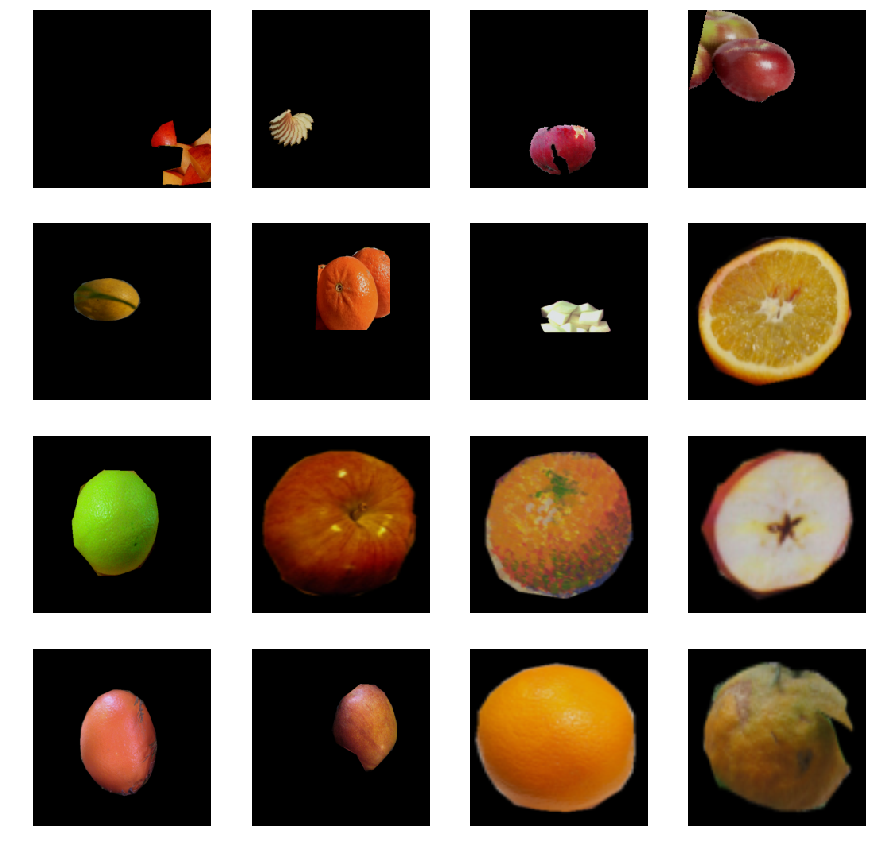

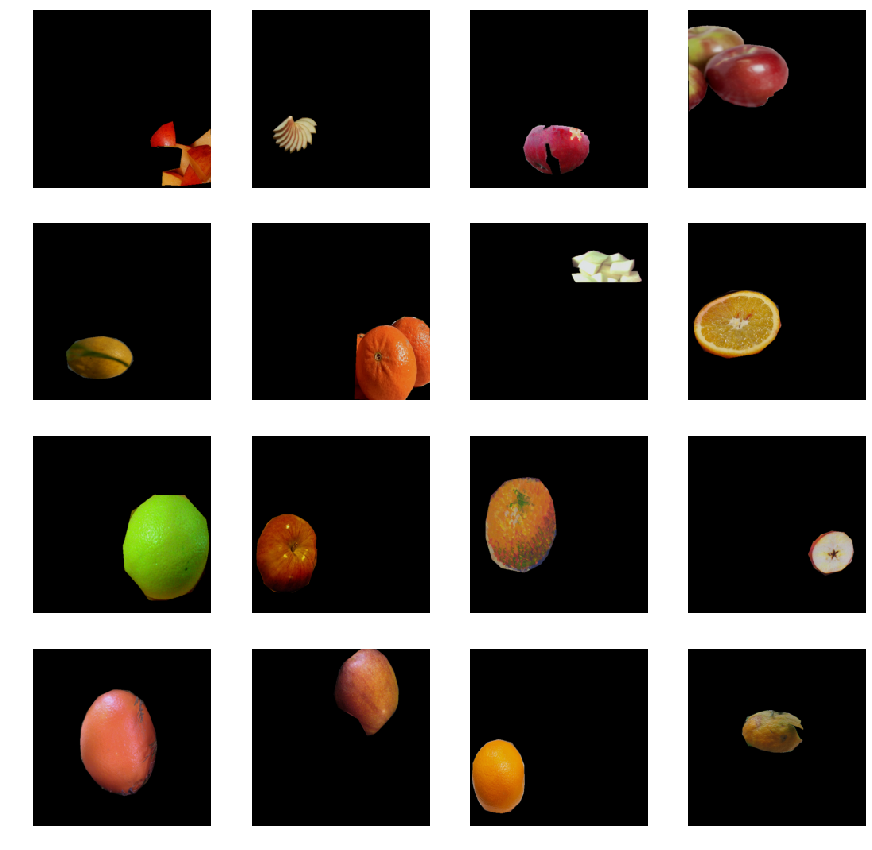

In [12]:


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2.subplots_adjust()
i = 0
j = 0

    
obj_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])

for im, masks, objs, mask_trans, obj_trans in  cocoloader:
    
    for obj, obj_tran in zip(objs, obj_trans):
        
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(obj_tran.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(np.swapaxes(np.swapaxes(obj.numpy(),0,1),1,2))
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [13]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [14]:
from torch import nn

In [15]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [16]:
n_batches

4

In [17]:
n_batches


4

In [18]:
def deTanh(x):
    return x.add(1).mul(0.5)

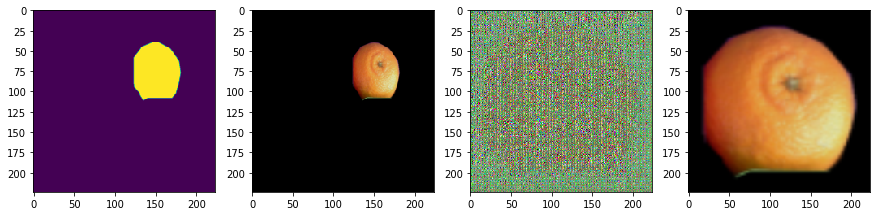

Epoch [0/20000], Step[4/4], d_loss: 0.8598, g_loss: 0.8598, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [10/20000], Step[4/4], d_loss: 0.3669, g_loss: 0.3669, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [20/20000], Step[4/4], d_loss: 0.1655, g_loss: 0.1655, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [30/20000], Step[4/4], d_loss: 0.1104, g_loss: 0.1104, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [40/20000], Step[4/4], d_loss: 0.0877, g_loss: 0.0877, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [50/20000], Step[4/4], d_loss: 0.0783, g_loss: 0.0783, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [60/20000], Step[4/4], d_loss: 0.0536, g_loss: 0.0536, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [70/20000], Step[4/4], d_loss: 0.0679, g_loss: 0.0679, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [80/20000], Step[4/4], d_loss: 0.0412, g_loss: 0.0412, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [90/20000], Step[4/4], d_loss: 0.0422, g_loss: 0.0422, Mean D(x): 0.00, Mean D(G(z)): 0.00


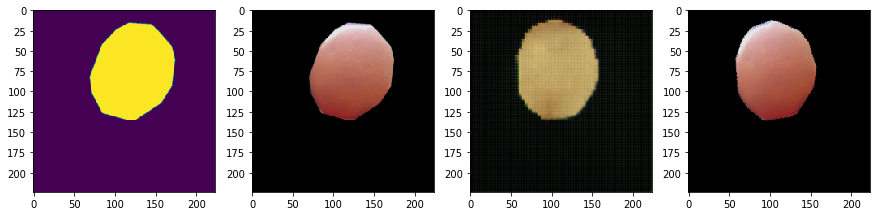

Epoch [100/20000], Step[4/4], d_loss: 0.0415, g_loss: 0.0415, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [110/20000], Step[4/4], d_loss: 0.0325, g_loss: 0.0325, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [120/20000], Step[4/4], d_loss: 0.0416, g_loss: 0.0416, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [130/20000], Step[4/4], d_loss: 0.0390, g_loss: 0.0390, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [140/20000], Step[4/4], d_loss: 0.0302, g_loss: 0.0302, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [150/20000], Step[4/4], d_loss: 0.0337, g_loss: 0.0337, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [160/20000], Step[4/4], d_loss: 0.0280, g_loss: 0.0280, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [170/20000], Step[4/4], d_loss: 0.0345, g_loss: 0.0345, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [440/20000], Step[4/4], d_loss: 0.0277, g_loss: 0.0277, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [450/20000], Step[4/4], d_loss: 0.0266, g_loss: 0.0266, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [460/20000], S

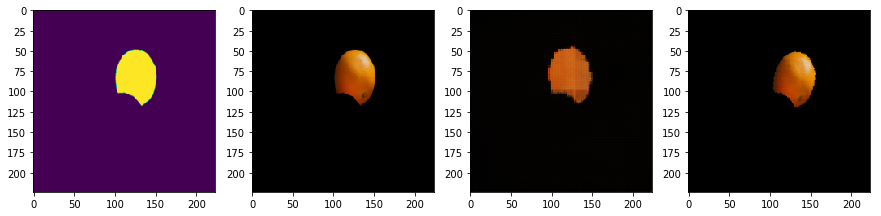

Epoch [500/20000], Step[4/4], d_loss: 0.0259, g_loss: 0.0259, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [510/20000], Step[4/4], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [520/20000], Step[4/4], d_loss: 0.0221, g_loss: 0.0221, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [530/20000], Step[4/4], d_loss: 0.0286, g_loss: 0.0286, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [540/20000], Step[4/4], d_loss: 0.0231, g_loss: 0.0231, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [550/20000], Step[4/4], d_loss: 0.0310, g_loss: 0.0310, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [560/20000], Step[4/4], d_loss: 0.0242, g_loss: 0.0242, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [570/20000], Step[4/4], d_loss: 0.0207, g_loss: 0.0207, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [580/20000], Step[4/4], d_loss: 0.0312, g_loss: 0.0312, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [590/20000], Step[4/4], d_loss: 0.0247, g_loss: 0.0247, Mean D(x): 0.00, Mean D(G(z)): 0.00


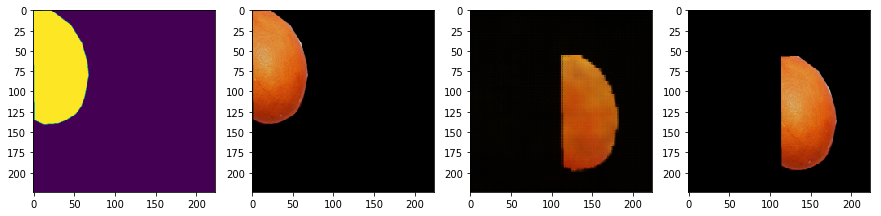

Epoch [600/20000], Step[4/4], d_loss: 0.0258, g_loss: 0.0258, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [610/20000], Step[4/4], d_loss: 0.0238, g_loss: 0.0238, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [620/20000], Step[4/4], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [630/20000], Step[4/4], d_loss: 0.0202, g_loss: 0.0202, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [640/20000], Step[4/4], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [650/20000], Step[4/4], d_loss: 0.0209, g_loss: 0.0209, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [660/20000], Step[4/4], d_loss: 0.0200, g_loss: 0.0200, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [670/20000], Step[4/4], d_loss: 0.0248, g_loss: 0.0248, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [680/20000], Step[4/4], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [690/20000], Step[4/4], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00


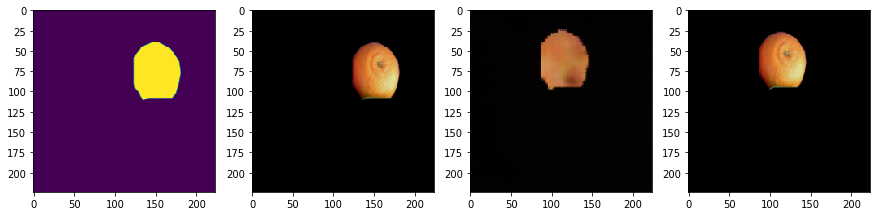

Epoch [700/20000], Step[4/4], d_loss: 0.0198, g_loss: 0.0198, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [710/20000], Step[4/4], d_loss: 0.0263, g_loss: 0.0263, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [720/20000], Step[4/4], d_loss: 0.0273, g_loss: 0.0273, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [730/20000], Step[4/4], d_loss: 0.0204, g_loss: 0.0204, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [740/20000], Step[4/4], d_loss: 0.0239, g_loss: 0.0239, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [750/20000], Step[4/4], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [760/20000], Step[4/4], d_loss: 0.0194, g_loss: 0.0194, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [770/20000], Step[4/4], d_loss: 0.0216, g_loss: 0.0216, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [780/20000], Step[4/4], d_loss: 0.0256, g_loss: 0.0256, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [790/20000], Step[4/4], d_loss: 0.0193, g_loss: 0.0193, Mean D(x): 0.00, Mean D(G(z)): 0.00


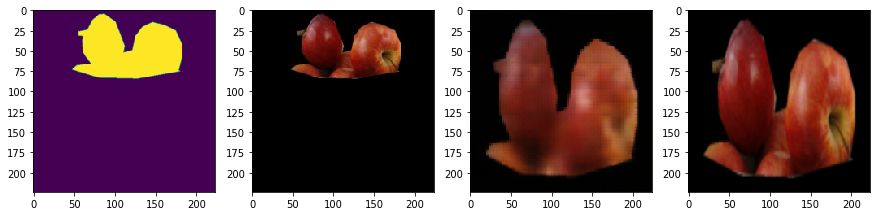

Epoch [800/20000], Step[4/4], d_loss: 0.0187, g_loss: 0.0187, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [810/20000], Step[4/4], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [820/20000], Step[4/4], d_loss: 0.0198, g_loss: 0.0198, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [830/20000], Step[4/4], d_loss: 0.0235, g_loss: 0.0235, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [840/20000], Step[4/4], d_loss: 0.0230, g_loss: 0.0230, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [850/20000], Step[4/4], d_loss: 0.0212, g_loss: 0.0212, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [860/20000], Step[4/4], d_loss: 0.0192, g_loss: 0.0192, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [870/20000], Step[4/4], d_loss: 0.0233, g_loss: 0.0233, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [880/20000], Step[4/4], d_loss: 0.0251, g_loss: 0.0251, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [890/20000], Step[4/4], d_loss: 0.0195, g_loss: 0.0195, Mean D(x): 0.00, Mean D(G(z)): 0.00


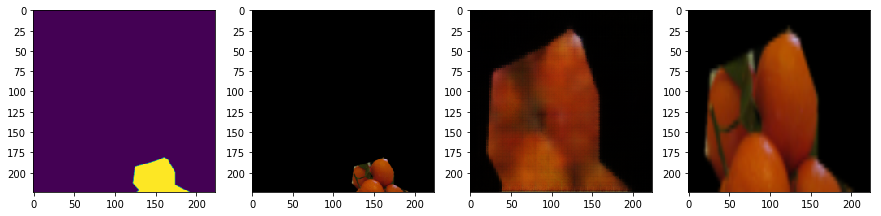

Epoch [900/20000], Step[4/4], d_loss: 0.0202, g_loss: 0.0202, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [910/20000], Step[4/4], d_loss: 0.0201, g_loss: 0.0201, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [920/20000], Step[4/4], d_loss: 0.0210, g_loss: 0.0210, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [930/20000], Step[4/4], d_loss: 0.0236, g_loss: 0.0236, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [940/20000], Step[4/4], d_loss: 0.0181, g_loss: 0.0181, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [950/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [960/20000], Step[4/4], d_loss: 0.0194, g_loss: 0.0194, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [970/20000], Step[4/4], d_loss: 0.0182, g_loss: 0.0182, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [980/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [990/20000], Step[4/4], d_loss: 0.0223, g_loss: 0.0223, Mean D(x): 0.00, Mean D(G(z)): 0.00


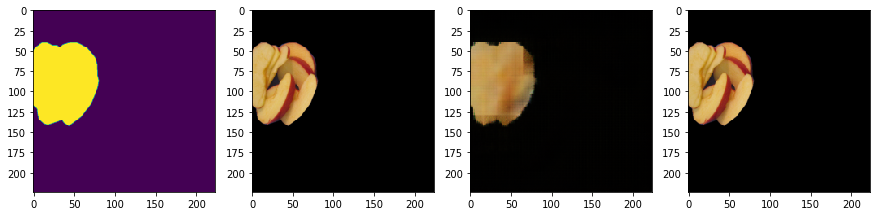

Epoch [1000/20000], Step[4/4], d_loss: 0.0208, g_loss: 0.0208, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1010/20000], Step[4/4], d_loss: 0.0190, g_loss: 0.0190, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1020/20000], Step[4/4], d_loss: 0.0213, g_loss: 0.0213, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1030/20000], Step[4/4], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1040/20000], Step[4/4], d_loss: 0.0154, g_loss: 0.0154, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1050/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1060/20000], Step[4/4], d_loss: 0.0246, g_loss: 0.0246, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1070/20000], Step[4/4], d_loss: 0.0254, g_loss: 0.0254, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1080/20000], Step[4/4], d_loss: 0.0214, g_loss: 0.0214, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1090/20000], Step[4/4], d_loss: 0.0179, g_loss: 0.0179, Mean D(x): 0.00, Mean D(G(z)): 0.00


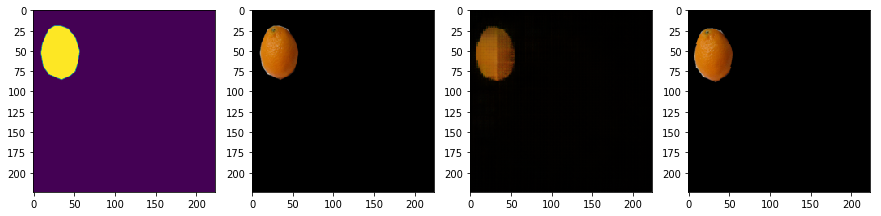

Epoch [1100/20000], Step[4/4], d_loss: 0.0201, g_loss: 0.0201, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1110/20000], Step[4/4], d_loss: 0.0174, g_loss: 0.0174, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1120/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1130/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1140/20000], Step[4/4], d_loss: 0.0222, g_loss: 0.0222, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1150/20000], Step[4/4], d_loss: 0.0223, g_loss: 0.0223, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1160/20000], Step[4/4], d_loss: 0.0222, g_loss: 0.0222, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1170/20000], Step[4/4], d_loss: 0.0219, g_loss: 0.0219, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1180/20000], Step[4/4], d_loss: 0.0217, g_loss: 0.0217, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1190/20000], Step[4/4], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00


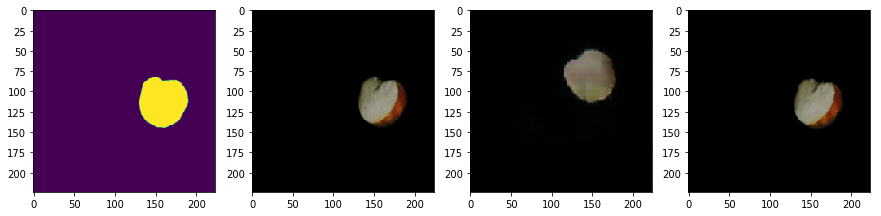

Epoch [1200/20000], Step[4/4], d_loss: 0.0188, g_loss: 0.0188, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1210/20000], Step[4/4], d_loss: 0.0207, g_loss: 0.0207, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1220/20000], Step[4/4], d_loss: 0.0205, g_loss: 0.0205, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1230/20000], Step[4/4], d_loss: 0.0165, g_loss: 0.0165, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1240/20000], Step[4/4], d_loss: 0.0176, g_loss: 0.0176, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1250/20000], Step[4/4], d_loss: 0.0249, g_loss: 0.0249, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1260/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1270/20000], Step[4/4], d_loss: 0.0182, g_loss: 0.0182, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1280/20000], Step[4/4], d_loss: 0.0202, g_loss: 0.0202, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1290/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00


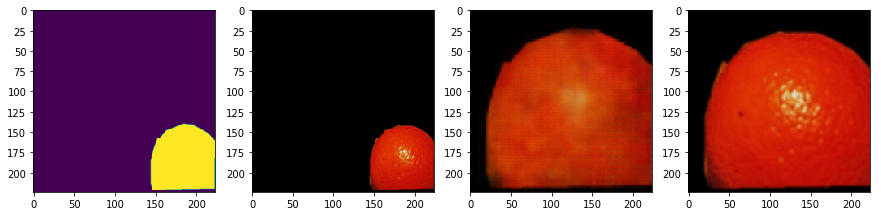

Epoch [1300/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1310/20000], Step[4/4], d_loss: 0.0185, g_loss: 0.0185, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1320/20000], Step[4/4], d_loss: 0.0167, g_loss: 0.0167, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1330/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1340/20000], Step[4/4], d_loss: 0.0180, g_loss: 0.0180, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1350/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1360/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1370/20000], Step[4/4], d_loss: 0.0197, g_loss: 0.0197, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1380/20000], Step[4/4], d_loss: 0.0182, g_loss: 0.0182, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1390/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00


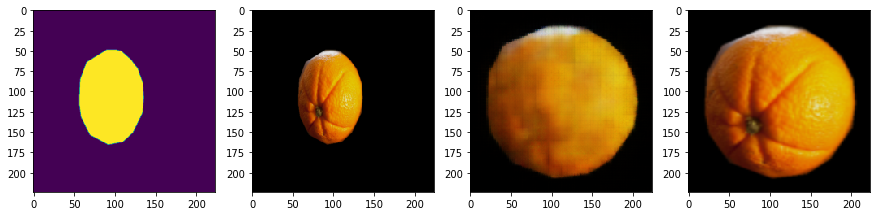

Epoch [1400/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1410/20000], Step[4/4], d_loss: 0.0235, g_loss: 0.0235, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1420/20000], Step[4/4], d_loss: 0.0196, g_loss: 0.0196, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1430/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1440/20000], Step[4/4], d_loss: 0.0165, g_loss: 0.0165, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1450/20000], Step[4/4], d_loss: 0.0186, g_loss: 0.0186, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1460/20000], Step[4/4], d_loss: 0.0195, g_loss: 0.0195, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1470/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1480/20000], Step[4/4], d_loss: 0.0198, g_loss: 0.0198, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1490/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00


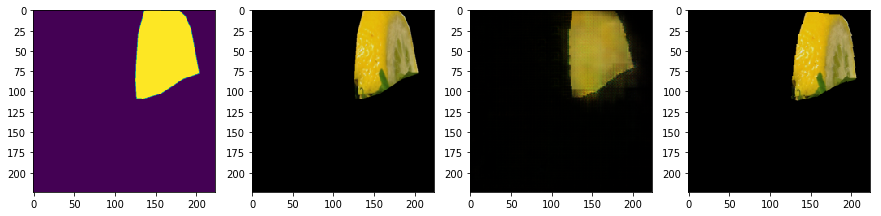

Epoch [1500/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1510/20000], Step[4/4], d_loss: 0.0182, g_loss: 0.0182, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1520/20000], Step[4/4], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1530/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1540/20000], Step[4/4], d_loss: 0.0187, g_loss: 0.0187, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1550/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1560/20000], Step[4/4], d_loss: 0.0210, g_loss: 0.0210, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1570/20000], Step[4/4], d_loss: 0.0234, g_loss: 0.0234, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1580/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1590/20000], Step[4/4], d_loss: 0.0224, g_loss: 0.0224, Mean D(x): 0.00, Mean D(G(z)): 0.00


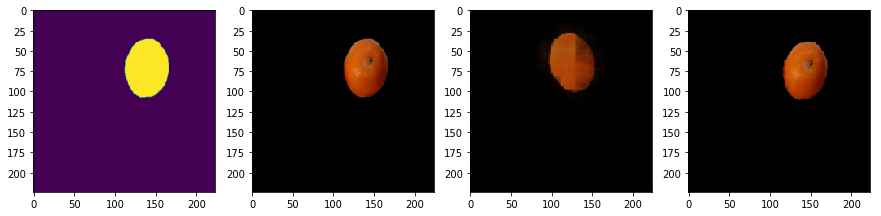

Epoch [1600/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1610/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1620/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1630/20000], Step[4/4], d_loss: 0.0217, g_loss: 0.0217, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1640/20000], Step[4/4], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1650/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1660/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1670/20000], Step[4/4], d_loss: 0.0133, g_loss: 0.0133, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1680/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1690/20000], Step[4/4], d_loss: 0.0190, g_loss: 0.0190, Mean D(x): 0.00, Mean D(G(z)): 0.00


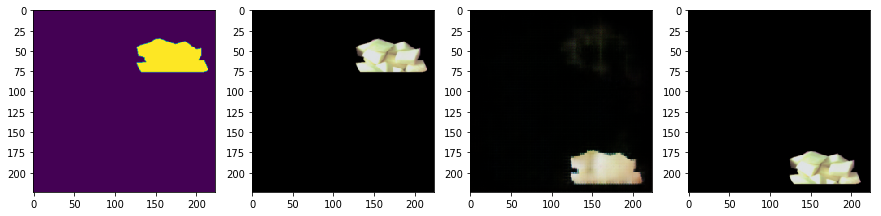

Epoch [1700/20000], Step[4/4], d_loss: 0.0187, g_loss: 0.0187, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1710/20000], Step[4/4], d_loss: 0.0189, g_loss: 0.0189, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1720/20000], Step[4/4], d_loss: 0.0187, g_loss: 0.0187, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1730/20000], Step[4/4], d_loss: 0.0138, g_loss: 0.0138, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1740/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1750/20000], Step[4/4], d_loss: 0.0134, g_loss: 0.0134, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1760/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1770/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1780/20000], Step[4/4], d_loss: 0.0181, g_loss: 0.0181, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1790/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00


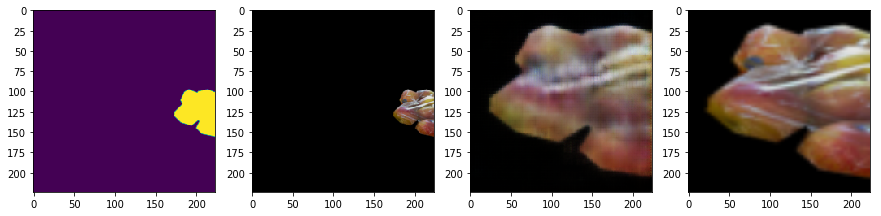

Epoch [1800/20000], Step[4/4], d_loss: 0.0138, g_loss: 0.0138, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1810/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1820/20000], Step[4/4], d_loss: 0.0194, g_loss: 0.0194, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1830/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1840/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1850/20000], Step[4/4], d_loss: 0.0237, g_loss: 0.0237, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1860/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1870/20000], Step[4/4], d_loss: 0.0125, g_loss: 0.0125, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1880/20000], Step[4/4], d_loss: 0.0193, g_loss: 0.0193, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1890/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00


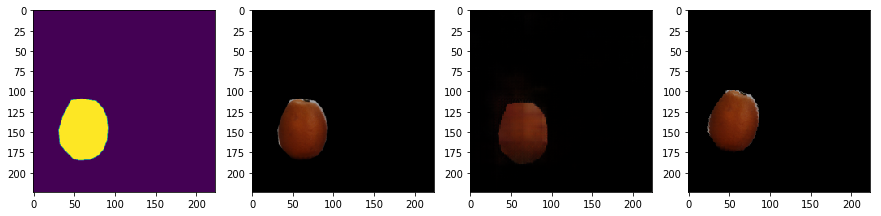

Epoch [1900/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1910/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1920/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1930/20000], Step[4/4], d_loss: 0.0191, g_loss: 0.0191, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1940/20000], Step[4/4], d_loss: 0.0192, g_loss: 0.0192, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1950/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1960/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1970/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1980/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [1990/20000], Step[4/4], d_loss: 0.0208, g_loss: 0.0208, Mean D(x): 0.00, Mean D(G(z)): 0.00


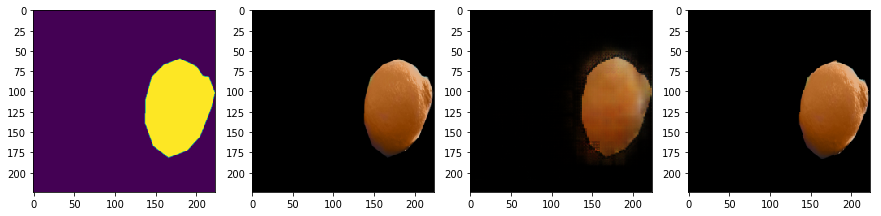

Epoch [2000/20000], Step[4/4], d_loss: 0.0201, g_loss: 0.0201, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2010/20000], Step[4/4], d_loss: 0.0189, g_loss: 0.0189, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2020/20000], Step[4/4], d_loss: 0.0152, g_loss: 0.0152, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2030/20000], Step[4/4], d_loss: 0.0211, g_loss: 0.0211, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2040/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2050/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2060/20000], Step[4/4], d_loss: 0.0189, g_loss: 0.0189, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2070/20000], Step[4/4], d_loss: 0.0131, g_loss: 0.0131, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2080/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2090/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00


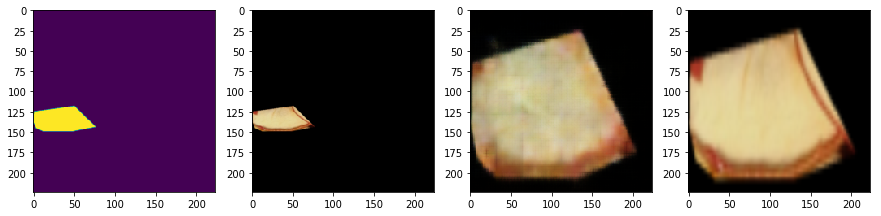

Epoch [2100/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2110/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2120/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2130/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2140/20000], Step[4/4], d_loss: 0.0195, g_loss: 0.0195, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2150/20000], Step[4/4], d_loss: 0.0220, g_loss: 0.0220, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2160/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2170/20000], Step[4/4], d_loss: 0.0186, g_loss: 0.0186, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2180/20000], Step[4/4], d_loss: 0.0185, g_loss: 0.0185, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2190/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00


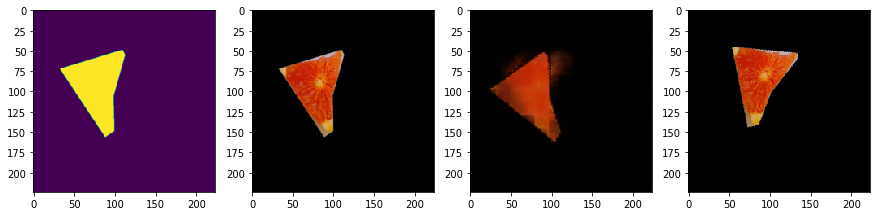

Epoch [2200/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2210/20000], Step[4/4], d_loss: 0.0194, g_loss: 0.0194, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2220/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2230/20000], Step[4/4], d_loss: 0.0167, g_loss: 0.0167, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2240/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2250/20000], Step[4/4], d_loss: 0.0132, g_loss: 0.0132, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2260/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2270/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2280/20000], Step[4/4], d_loss: 0.0198, g_loss: 0.0198, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2290/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00


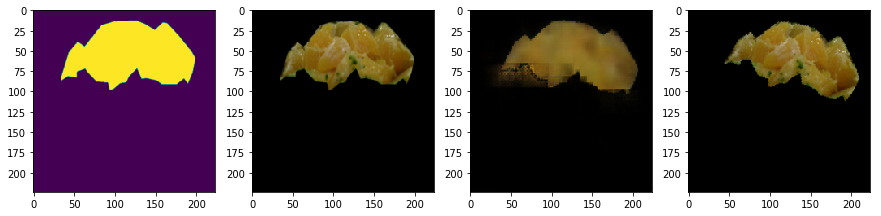

Epoch [2300/20000], Step[4/4], d_loss: 0.0159, g_loss: 0.0159, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2310/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2320/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2330/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2340/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2350/20000], Step[4/4], d_loss: 0.0190, g_loss: 0.0190, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2360/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2370/20000], Step[4/4], d_loss: 0.0197, g_loss: 0.0197, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2380/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2390/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00


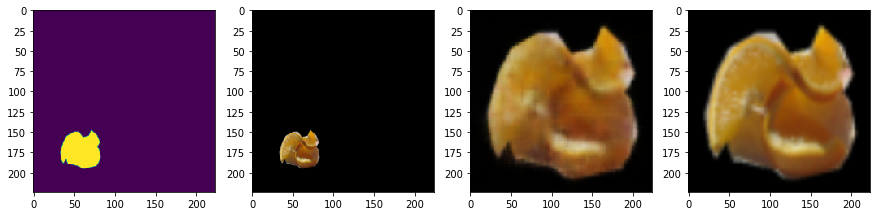

Epoch [2400/20000], Step[4/4], d_loss: 0.0167, g_loss: 0.0167, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2410/20000], Step[4/4], d_loss: 0.0199, g_loss: 0.0199, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2420/20000], Step[4/4], d_loss: 0.0208, g_loss: 0.0208, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2430/20000], Step[4/4], d_loss: 0.0196, g_loss: 0.0196, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2440/20000], Step[4/4], d_loss: 0.0158, g_loss: 0.0158, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2450/20000], Step[4/4], d_loss: 0.0212, g_loss: 0.0212, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2460/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2470/20000], Step[4/4], d_loss: 0.0150, g_loss: 0.0150, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2480/20000], Step[4/4], d_loss: 0.0194, g_loss: 0.0194, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2490/20000], Step[4/4], d_loss: 0.0189, g_loss: 0.0189, Mean D(x): 0.00, Mean D(G(z)): 0.00


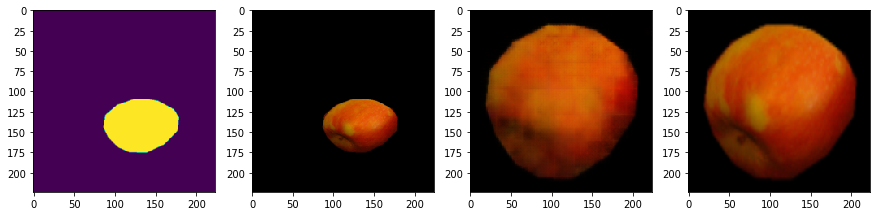

Epoch [2500/20000], Step[4/4], d_loss: 0.0174, g_loss: 0.0174, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2510/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2520/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2530/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2540/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2550/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2560/20000], Step[4/4], d_loss: 0.0165, g_loss: 0.0165, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2570/20000], Step[4/4], d_loss: 0.0191, g_loss: 0.0191, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2580/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2590/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00


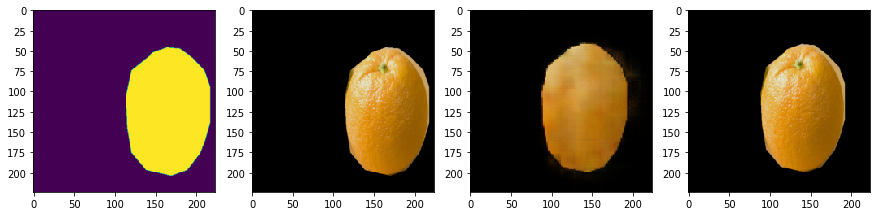

Epoch [2600/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2610/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2620/20000], Step[4/4], d_loss: 0.0127, g_loss: 0.0127, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2630/20000], Step[4/4], d_loss: 0.0132, g_loss: 0.0132, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2640/20000], Step[4/4], d_loss: 0.0146, g_loss: 0.0146, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2650/20000], Step[4/4], d_loss: 0.0133, g_loss: 0.0133, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2660/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2670/20000], Step[4/4], d_loss: 0.0186, g_loss: 0.0186, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2680/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2690/20000], Step[4/4], d_loss: 0.0130, g_loss: 0.0130, Mean D(x): 0.00, Mean D(G(z)): 0.00


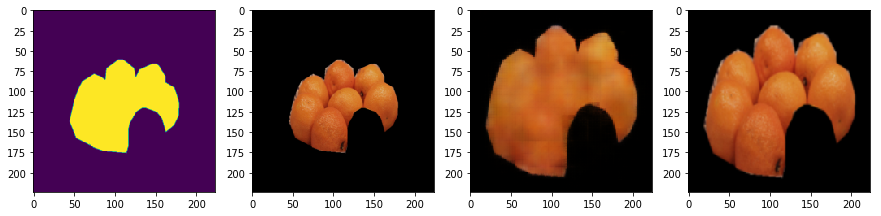

Epoch [2700/20000], Step[4/4], d_loss: 0.0165, g_loss: 0.0165, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2710/20000], Step[4/4], d_loss: 0.0220, g_loss: 0.0220, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2720/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2730/20000], Step[4/4], d_loss: 0.0229, g_loss: 0.0229, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2740/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2750/20000], Step[4/4], d_loss: 0.0196, g_loss: 0.0196, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2760/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2770/20000], Step[4/4], d_loss: 0.0159, g_loss: 0.0159, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2780/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2790/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00


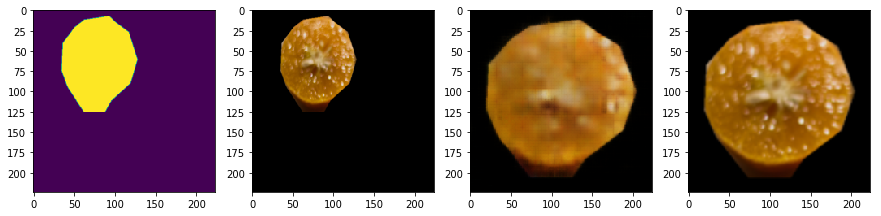

Epoch [2800/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2810/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2820/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2830/20000], Step[4/4], d_loss: 0.0200, g_loss: 0.0200, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2840/20000], Step[4/4], d_loss: 0.0165, g_loss: 0.0165, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2850/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2860/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2870/20000], Step[4/4], d_loss: 0.0118, g_loss: 0.0118, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2880/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2890/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00


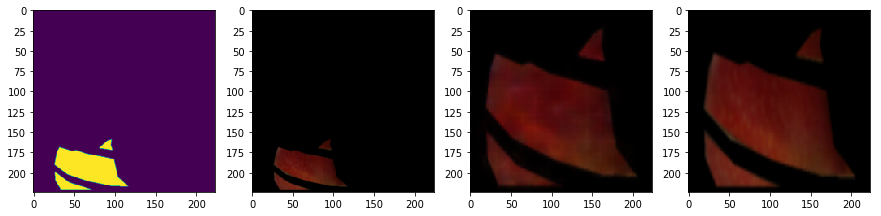

Epoch [2900/20000], Step[4/4], d_loss: 0.0122, g_loss: 0.0122, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2910/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2920/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2930/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2940/20000], Step[4/4], d_loss: 0.0123, g_loss: 0.0123, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2950/20000], Step[4/4], d_loss: 0.0191, g_loss: 0.0191, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2960/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2970/20000], Step[4/4], d_loss: 0.0127, g_loss: 0.0127, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2980/20000], Step[4/4], d_loss: 0.0179, g_loss: 0.0179, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [2990/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00


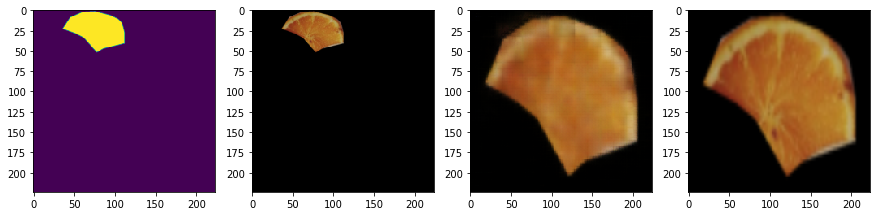

Epoch [3000/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3010/20000], Step[4/4], d_loss: 0.0132, g_loss: 0.0132, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3020/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3030/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3040/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3050/20000], Step[4/4], d_loss: 0.0179, g_loss: 0.0179, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3060/20000], Step[4/4], d_loss: 0.0186, g_loss: 0.0186, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3070/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3080/20000], Step[4/4], d_loss: 0.0195, g_loss: 0.0195, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3090/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00


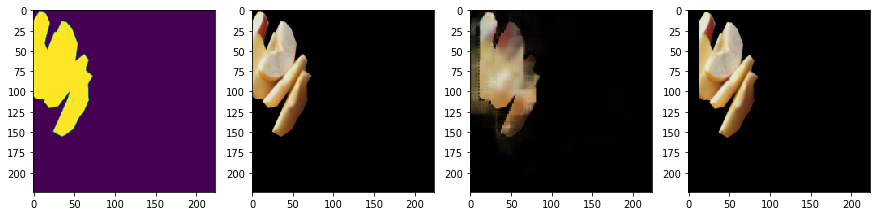

Epoch [3100/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3110/20000], Step[4/4], d_loss: 0.0159, g_loss: 0.0159, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3120/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3130/20000], Step[4/4], d_loss: 0.0143, g_loss: 0.0143, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3140/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3150/20000], Step[4/4], d_loss: 0.0181, g_loss: 0.0181, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3160/20000], Step[4/4], d_loss: 0.0192, g_loss: 0.0192, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3170/20000], Step[4/4], d_loss: 0.0181, g_loss: 0.0181, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3180/20000], Step[4/4], d_loss: 0.0150, g_loss: 0.0150, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3190/20000], Step[4/4], d_loss: 0.0136, g_loss: 0.0136, Mean D(x): 0.00, Mean D(G(z)): 0.00


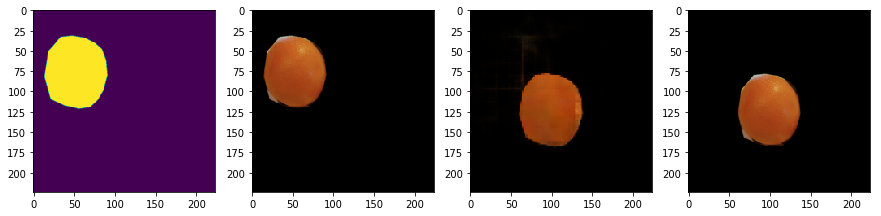

Epoch [3200/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3210/20000], Step[4/4], d_loss: 0.0125, g_loss: 0.0125, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3220/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3230/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3240/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3250/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3260/20000], Step[4/4], d_loss: 0.0152, g_loss: 0.0152, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3270/20000], Step[4/4], d_loss: 0.0143, g_loss: 0.0143, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3280/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3290/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00


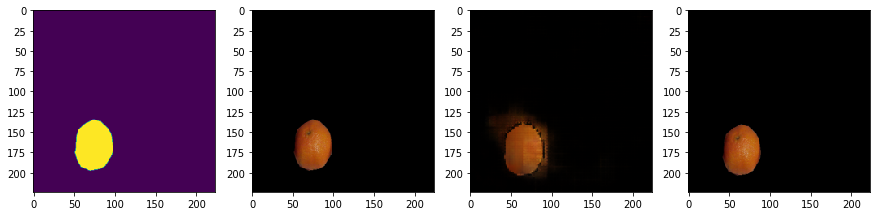

Epoch [3300/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3310/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3320/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3330/20000], Step[4/4], d_loss: 0.0182, g_loss: 0.0182, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3340/20000], Step[4/4], d_loss: 0.0129, g_loss: 0.0129, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3350/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3360/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3370/20000], Step[4/4], d_loss: 0.0185, g_loss: 0.0185, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3380/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3390/20000], Step[4/4], d_loss: 0.0185, g_loss: 0.0185, Mean D(x): 0.00, Mean D(G(z)): 0.00


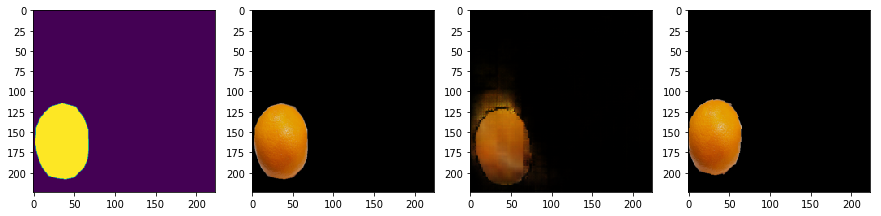

Epoch [3400/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3410/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3420/20000], Step[4/4], d_loss: 0.0141, g_loss: 0.0141, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3430/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3440/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3450/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3460/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3470/20000], Step[4/4], d_loss: 0.0152, g_loss: 0.0152, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3480/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3490/20000], Step[4/4], d_loss: 0.0193, g_loss: 0.0193, Mean D(x): 0.00, Mean D(G(z)): 0.00


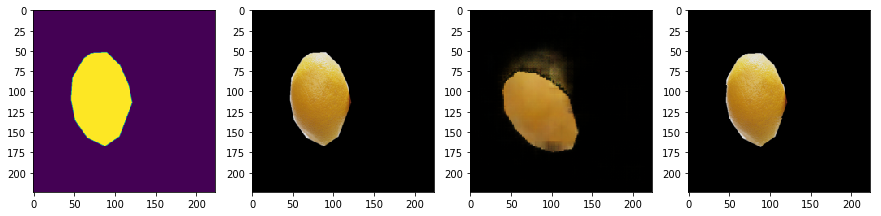

Epoch [3500/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3510/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3520/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3530/20000], Step[4/4], d_loss: 0.0200, g_loss: 0.0200, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3540/20000], Step[4/4], d_loss: 0.0212, g_loss: 0.0212, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3550/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3560/20000], Step[4/4], d_loss: 0.0158, g_loss: 0.0158, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3570/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3580/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3590/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00


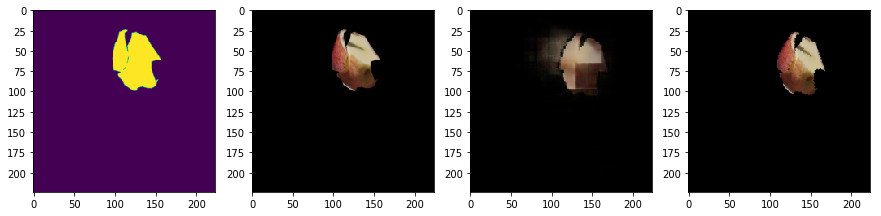

Epoch [3600/20000], Step[4/4], d_loss: 0.0158, g_loss: 0.0158, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3610/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3620/20000], Step[4/4], d_loss: 0.0150, g_loss: 0.0150, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3630/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3640/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3650/20000], Step[4/4], d_loss: 0.0130, g_loss: 0.0130, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3660/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3670/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3680/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3690/20000], Step[4/4], d_loss: 0.0154, g_loss: 0.0154, Mean D(x): 0.00, Mean D(G(z)): 0.00


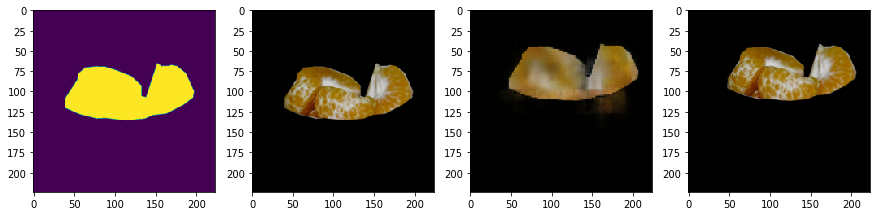

Epoch [3700/20000], Step[4/4], d_loss: 0.0150, g_loss: 0.0150, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3710/20000], Step[4/4], d_loss: 0.0136, g_loss: 0.0136, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3720/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3730/20000], Step[4/4], d_loss: 0.0152, g_loss: 0.0152, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3740/20000], Step[4/4], d_loss: 0.0149, g_loss: 0.0149, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3750/20000], Step[4/4], d_loss: 0.0174, g_loss: 0.0174, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3760/20000], Step[4/4], d_loss: 0.0135, g_loss: 0.0135, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3770/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3780/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3790/20000], Step[4/4], d_loss: 0.0136, g_loss: 0.0136, Mean D(x): 0.00, Mean D(G(z)): 0.00


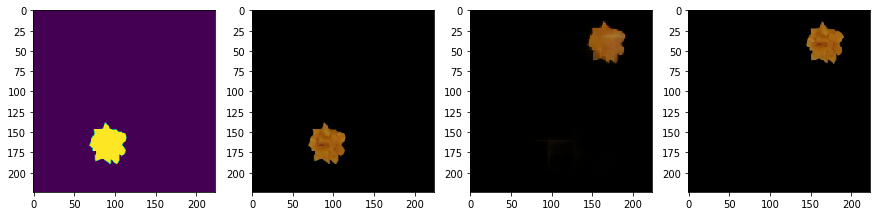

Epoch [3800/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3810/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3820/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3830/20000], Step[4/4], d_loss: 0.0149, g_loss: 0.0149, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3840/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3850/20000], Step[4/4], d_loss: 0.0164, g_loss: 0.0164, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3860/20000], Step[4/4], d_loss: 0.0162, g_loss: 0.0162, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3870/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3880/20000], Step[4/4], d_loss: 0.0149, g_loss: 0.0149, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3890/20000], Step[4/4], d_loss: 0.0208, g_loss: 0.0208, Mean D(x): 0.00, Mean D(G(z)): 0.00


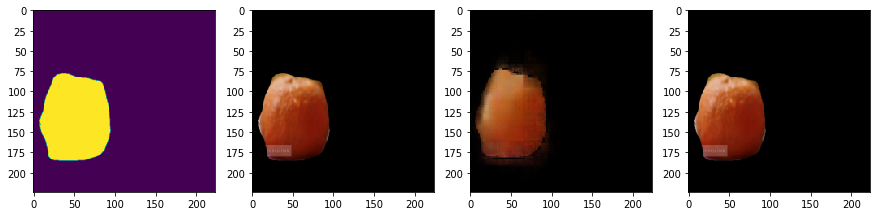

Epoch [3900/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3910/20000], Step[4/4], d_loss: 0.0156, g_loss: 0.0156, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3920/20000], Step[4/4], d_loss: 0.0168, g_loss: 0.0168, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3930/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3940/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3950/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3960/20000], Step[4/4], d_loss: 0.0176, g_loss: 0.0176, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3970/20000], Step[4/4], d_loss: 0.0174, g_loss: 0.0174, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3980/20000], Step[4/4], d_loss: 0.0190, g_loss: 0.0190, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [3990/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00


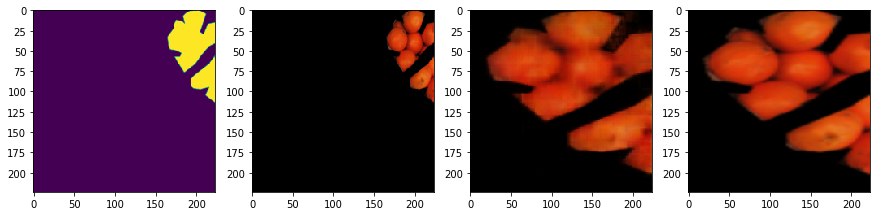

Epoch [4000/20000], Step[4/4], d_loss: 0.0181, g_loss: 0.0181, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4010/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4020/20000], Step[4/4], d_loss: 0.0138, g_loss: 0.0138, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4030/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4040/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4050/20000], Step[4/4], d_loss: 0.0170, g_loss: 0.0170, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4060/20000], Step[4/4], d_loss: 0.0138, g_loss: 0.0138, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4070/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4080/20000], Step[4/4], d_loss: 0.0126, g_loss: 0.0126, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4090/20000], Step[4/4], d_loss: 0.0159, g_loss: 0.0159, Mean D(x): 0.00, Mean D(G(z)): 0.00


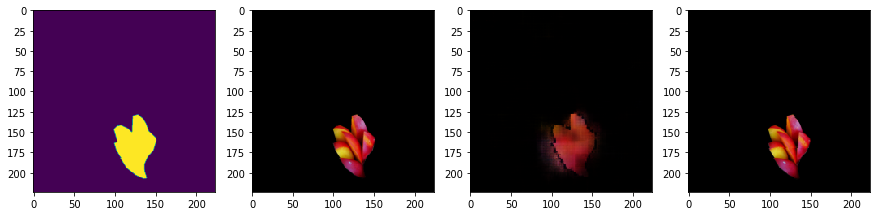

Epoch [4100/20000], Step[4/4], d_loss: 0.0195, g_loss: 0.0195, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4110/20000], Step[4/4], d_loss: 0.0126, g_loss: 0.0126, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4120/20000], Step[4/4], d_loss: 0.0154, g_loss: 0.0154, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4130/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4140/20000], Step[4/4], d_loss: 0.0143, g_loss: 0.0143, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4150/20000], Step[4/4], d_loss: 0.0185, g_loss: 0.0185, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4160/20000], Step[4/4], d_loss: 0.0189, g_loss: 0.0189, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4170/20000], Step[4/4], d_loss: 0.0127, g_loss: 0.0127, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4180/20000], Step[4/4], d_loss: 0.0136, g_loss: 0.0136, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4190/20000], Step[4/4], d_loss: 0.0198, g_loss: 0.0198, Mean D(x): 0.00, Mean D(G(z)): 0.00


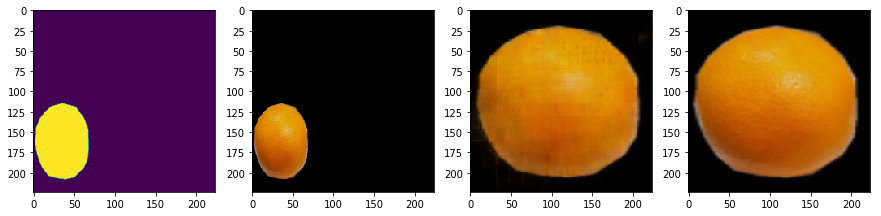

Epoch [4200/20000], Step[4/4], d_loss: 0.0122, g_loss: 0.0122, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4210/20000], Step[4/4], d_loss: 0.0150, g_loss: 0.0150, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4220/20000], Step[4/4], d_loss: 0.0171, g_loss: 0.0171, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4230/20000], Step[4/4], d_loss: 0.0132, g_loss: 0.0132, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4240/20000], Step[4/4], d_loss: 0.0124, g_loss: 0.0124, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4250/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4260/20000], Step[4/4], d_loss: 0.0112, g_loss: 0.0112, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4270/20000], Step[4/4], d_loss: 0.0122, g_loss: 0.0122, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4280/20000], Step[4/4], d_loss: 0.0108, g_loss: 0.0108, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4290/20000], Step[4/4], d_loss: 0.0138, g_loss: 0.0138, Mean D(x): 0.00, Mean D(G(z)): 0.00


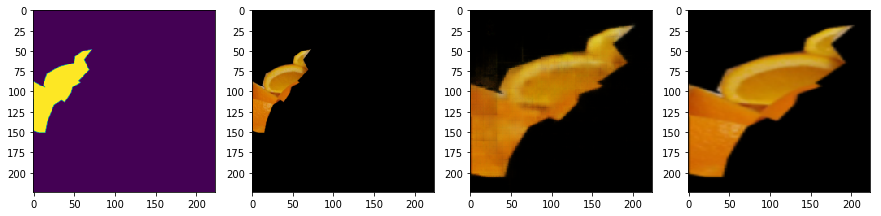

Epoch [4300/20000], Step[4/4], d_loss: 0.0125, g_loss: 0.0125, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4310/20000], Step[4/4], d_loss: 0.0130, g_loss: 0.0130, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4320/20000], Step[4/4], d_loss: 0.0115, g_loss: 0.0115, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4330/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4340/20000], Step[4/4], d_loss: 0.0122, g_loss: 0.0122, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4350/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4360/20000], Step[4/4], d_loss: 0.0142, g_loss: 0.0142, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4370/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4380/20000], Step[4/4], d_loss: 0.0139, g_loss: 0.0139, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4390/20000], Step[4/4], d_loss: 0.0226, g_loss: 0.0226, Mean D(x): 0.00, Mean D(G(z)): 0.00


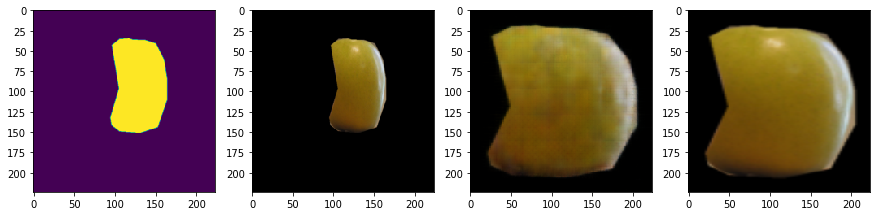

Epoch [4400/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4410/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4420/20000], Step[4/4], d_loss: 0.0135, g_loss: 0.0135, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4430/20000], Step[4/4], d_loss: 0.0143, g_loss: 0.0143, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4440/20000], Step[4/4], d_loss: 0.0126, g_loss: 0.0126, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4450/20000], Step[4/4], d_loss: 0.0183, g_loss: 0.0183, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4460/20000], Step[4/4], d_loss: 0.0177, g_loss: 0.0177, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4470/20000], Step[4/4], d_loss: 0.0154, g_loss: 0.0154, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4480/20000], Step[4/4], d_loss: 0.0104, g_loss: 0.0104, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4490/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00


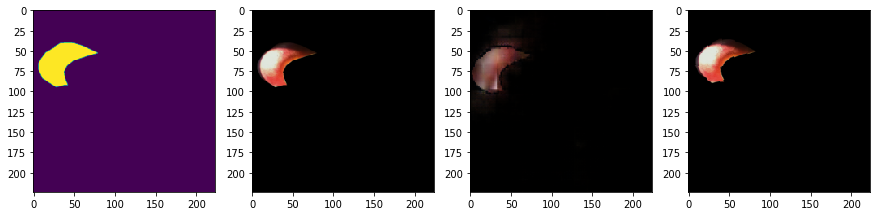

Epoch [4500/20000], Step[4/4], d_loss: 0.0125, g_loss: 0.0125, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4510/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4520/20000], Step[4/4], d_loss: 0.0127, g_loss: 0.0127, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4530/20000], Step[4/4], d_loss: 0.0141, g_loss: 0.0141, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4540/20000], Step[4/4], d_loss: 0.0137, g_loss: 0.0137, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4550/20000], Step[4/4], d_loss: 0.0151, g_loss: 0.0151, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4560/20000], Step[4/4], d_loss: 0.0180, g_loss: 0.0180, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4570/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4580/20000], Step[4/4], d_loss: 0.0166, g_loss: 0.0166, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4590/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00


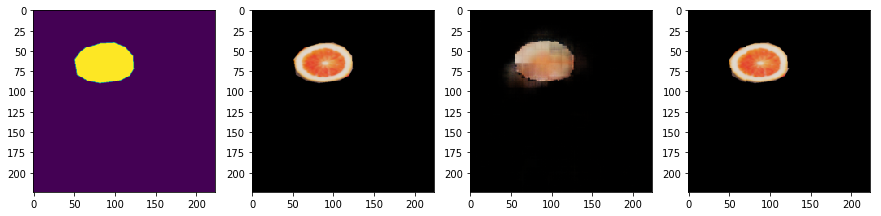

Epoch [4600/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4610/20000], Step[4/4], d_loss: 0.0161, g_loss: 0.0161, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4620/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4630/20000], Step[4/4], d_loss: 0.0124, g_loss: 0.0124, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4640/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4650/20000], Step[4/4], d_loss: 0.0158, g_loss: 0.0158, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4660/20000], Step[4/4], d_loss: 0.0155, g_loss: 0.0155, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4670/20000], Step[4/4], d_loss: 0.0160, g_loss: 0.0160, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4680/20000], Step[4/4], d_loss: 0.0175, g_loss: 0.0175, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4690/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00


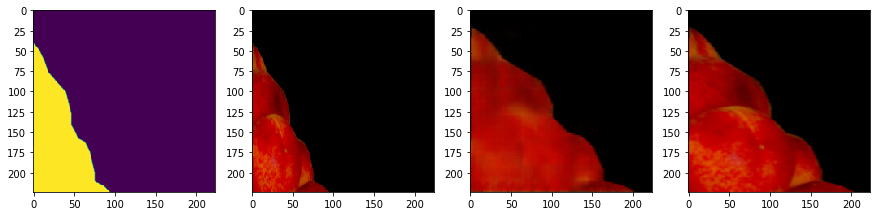

Epoch [4700/20000], Step[4/4], d_loss: 0.0140, g_loss: 0.0140, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4710/20000], Step[4/4], d_loss: 0.0167, g_loss: 0.0167, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4720/20000], Step[4/4], d_loss: 0.0178, g_loss: 0.0178, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4730/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4740/20000], Step[4/4], d_loss: 0.0179, g_loss: 0.0179, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4750/20000], Step[4/4], d_loss: 0.0149, g_loss: 0.0149, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4760/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4770/20000], Step[4/4], d_loss: 0.0173, g_loss: 0.0173, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4780/20000], Step[4/4], d_loss: 0.0110, g_loss: 0.0110, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4790/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00


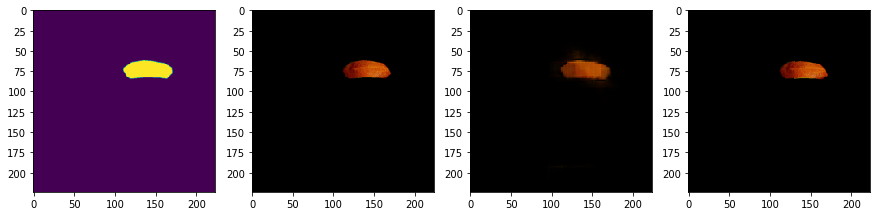

Epoch [4800/20000], Step[4/4], d_loss: 0.0144, g_loss: 0.0144, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4810/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4820/20000], Step[4/4], d_loss: 0.0123, g_loss: 0.0123, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4830/20000], Step[4/4], d_loss: 0.0109, g_loss: 0.0109, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4840/20000], Step[4/4], d_loss: 0.0157, g_loss: 0.0157, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4850/20000], Step[4/4], d_loss: 0.0184, g_loss: 0.0184, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4860/20000], Step[4/4], d_loss: 0.0187, g_loss: 0.0187, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4870/20000], Step[4/4], d_loss: 0.0146, g_loss: 0.0146, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4880/20000], Step[4/4], d_loss: 0.0168, g_loss: 0.0168, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4890/20000], Step[4/4], d_loss: 0.0172, g_loss: 0.0172, Mean D(x): 0.00, Mean D(G(z)): 0.00


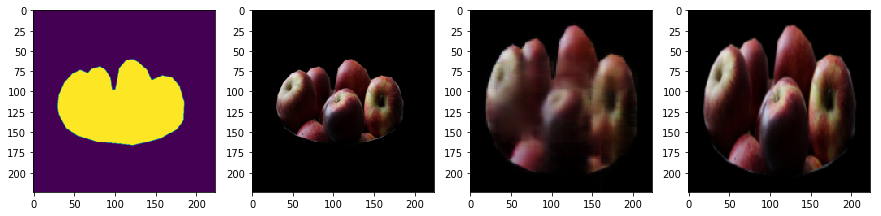

Epoch [4900/20000], Step[4/4], d_loss: 0.0153, g_loss: 0.0153, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4910/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4920/20000], Step[4/4], d_loss: 0.0145, g_loss: 0.0145, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4930/20000], Step[4/4], d_loss: 0.0169, g_loss: 0.0169, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4940/20000], Step[4/4], d_loss: 0.0163, g_loss: 0.0163, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4950/20000], Step[4/4], d_loss: 0.0148, g_loss: 0.0148, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4960/20000], Step[4/4], d_loss: 0.0180, g_loss: 0.0180, Mean D(x): 0.00, Mean D(G(z)): 0.00
Epoch [4970/20000], Step[4/4], d_loss: 0.0167, g_loss: 0.0167, Mean D(x): 0.00, Mean D(G(z)): 0.00


In [ ]:
# dae = DAE(IMAGE_SIZE)
# dae.load_state_dict(torch.load('./weights_mask_trans/dae-500.pkl'))
from models.model_AE_VGG16_2 import AE_VGG16_2
ae_vgg16 = AE_VGG16_2(IMAGE_SIZE)
model = ae_vgg16
#model.load_state_dict(torch.load('./Experiments/horseandzebra/weight/last_weight.pkl'))
#check_point_path = './Experiments/horseandzebra/weight/last_weight.pkl'
#d2 =  {str(k)[7:]:v for k,v in torch.load(check_point_path).items()}
#model.load_state_dict(d2)
if cuda:
    model.cuda()
model = nn.DataParallel(model)
num_epochs = 20000
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
f_result = open(save_path + '/weight/train_loss.txt', 'w')
f_result.close()
'''
for epoch in range(num_epochs + 1):
    f_result = open(save_path + '/weight/train_loss.txt', 'a')
    total_loss = 0
    epoch_start = True # quick hack
    #epoch += 20000
    for I, (images, masks, objs, mask_trans, objs_trans) in enumerate(cocoloader):
        #target_imgs = np.zeros_like(images)
        #target_masks = np.zeros_like(masks)
        
        #images = np.multiply(images,masks)
        #print(images[0])
        if cuda:
            images = Variable(images).cuda()
            masks = Variable(masks).cuda()
            objs = Variable(objs).cuda()
            mask_trans = Variable(mask_trans).cuda()
            objs_trans = Variable(objs_trans).cuda()
            
            images_train = Variable(images).cuda().mul(2).add(-1)
            masks_train = Variable(masks).cuda().mul(2).add(-1)
            objs_train = Variable(objs).cuda().mul(2).add(-1)
            mask_trans_train = Variable(mask_trans).cuda().mul(2).add(-1)
            objs_trans_train = Variable(objs_trans).cuda().mul(2).add(-1)
        else:
            images = Variable(images)
            masks = Variable(masks)
            objs = Variable(objs)
            mask_trans = Variable(mask_trans)
            objs_trans = Variable(objs_trans)
            images_train = Variable(images).mul(2).add(-1)
            masks_train = Variable(masks).mul(2).add(-1)
            objs_train = Variable(objs).mul(2).add(-1)
            mask_trans_train = Variable(mask_trans).mul(2).add(-1)
            objs_trans_train = Variable(objs_trans).mul(2).add(-1)
        '''    
        #transform all images in the batch with different transforms. 
        for i in range(x.shape[0]):
            rmin, rmax, cmin, cmax =  cocoDataset.bbox(masks[i][0].data.cpu().numpy())
            
            cx = randint(0 - cmin,  IMAGE_SIZE - cmax )
            ry = randint(0 - rmin,  IMAGE_SIZE - rmax )
            
            target_image = np.zeros((3,IMAGE_SIZE, IMAGE_SIZE))
            target_mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
            
            target_image[:,rmin + ry : rmax + ry, cmin + cx : cmax + cx] = images[i][:,rmin : rmax, cmin : cmax]
            target_mask[rmin + ry : rmax + ry, cmin + cx : cmax + cx] = masks[i][0][rmin : rmax, cmin : cmax].data.cpu().numpy()
            curr_img = images[i].data.cpu().numpy() * masks[i][0].data.cpu().numpy()
            tar_img = target_image * target_mask
            
            target_imgs[i] = tar_img
            target_masks[i][0] = target_mask
            #print(np.multiply(image,mask))
            #print(target_image)
#             if(epoch_start):
#                 f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

#                 axarr[0].imshow(masks[i][0].data.cpu().numpy())
#                 axarr[1].imshow(target_mask)
#                 axarr[2].imshow(np.swapaxes(np.swapaxes(curr_img,0,1),1,2))
#                 axarr[3].imshow(np.swapaxes(np.swapaxes(tar_img,0,1),1,2))

#                 plt.show()
#                 epoch_start = False
#             break
#             input()
            #print(cx, ry)
        '''
#         if cuda:
#             target_imgs = Variable(torch.from_numpy(target_imgs)).cuda()
#             target_masks = Variable(torch.from_numpy(target_masks)).cuda()
#         else:
#             target_imgs = Variable(target_imgs)
#             target_masks = Variable(target_masks)
            
        optimizer.zero_grad()
        z, x_hat = model(objs_train, mask_trans_train)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, objs_trans_train)
        loss.backward()
        optimizer.step()
        #quick hack 
        if(epoch_start and epoch%100 == 0):
            f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

            axarr[0].imshow(masks[0][0].data.cpu().numpy())
            axarr[1].imshow(np.swapaxes(np.swapaxes(objs[0].data.cpu().numpy(),0,1),1,2))
            axarr[2].imshow(np.swapaxes(np.swapaxes(deTanh(x_hat[0]).data.cpu().numpy(),0,1),1,2))
            axarr[3].imshow(np.swapaxes(np.swapaxes(objs_trans[0].data.cpu().numpy(),0,1),1,2))

            plt.show()
#             pdb.set_trace()
            save_image(torch.cat((objs[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  deTanh(x_hat[0]).data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  objs_trans[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE)), dim = 0)
                                   , save_path + '/images/fake_inside-%0.3d.png' %(epoch + 1))
            
            epoch_start = False


        '''
        if (i + 1) % 1 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.data[0]))
            torch.save(dae.state_dict(), 'dae-test-model.pkl')
        '''
        total_loss += loss.item()
        if (I + 1) % n_batches == 0 and epoch % 10 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Mean D(x): %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    I + 1,
                    n_batches,
                    loss.data,
                    loss.data,
                    0,
                    0)
            )

    #Save the image
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
        save_image(images.data, save_path + '/images/real_images.png')
        
    fake_images = deTanh(x_hat)
    
    
    if(epoch%100 == 0):
        save_image(fake_images.data, save_path + '/images/fake_images-%0.3d.png' %(epoch + 1))
    #print(total_loss)
    
    f_result.write("Epoch: {}, train_loss: {}\n".format(epoch + 1, str(total_loss)))
    f_result.close()
    
    # Save the trained parameters 
    #if (epoch + 1) % 500 == 0:
    torch.save(model.state_dict(), save_path + '/weight/last_weight.pkl')
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        